In [2]:
#引入一些必要librairies

import numpy as np # 數學處理
import pandas as pd # 資料處理和csv file 的 IO
%matplotlib inline
import matplotlib.pyplot as plt  # 畫圖用
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #忽略一些來自skleanr 和 seaborn 的錯誤訊息


from scipy import stats
from scipy.stats import norm, skew # 關於統計用


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #讓pd最多印出3個小數點


In [3]:
#引入訓練和測驗的Data

train = pd.read_csv('../House_Prices/data/train.csv', index_col="Id")
test = pd.read_csv('../House_Prices/data/test.csv', index_col="Id")


In [4]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))


#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))


The train data size before dropping Id feature is : (1460, 80) 
The test data size before dropping Id feature is : (1459, 79) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


# Data Processing

## Outliers(離群值)

[Documentation][1] for the Ames Housing Data indicates that there are outliers present in the training data
[1]: http://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt

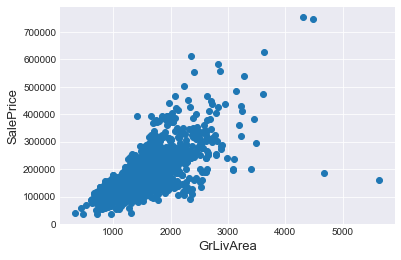

In [5]:
#畫出 GrLivArea 和SalePrice兩個column對應的圖
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()


看得出右下角有兩個點十分明顯，在GrLivArea>4000和SalePrice<300000的地方

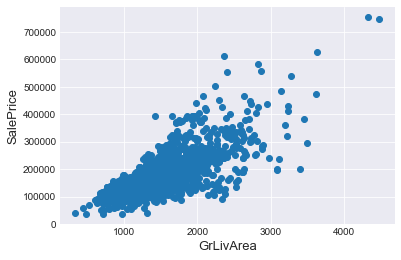

In [13]:
#刪掉 outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#重新檢視那張圖
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

### Note : 
 我們只選擇那些真的和其他差距非常大的outlier來去除，或許還存在其它的，但我們移除掉全部或許會影響到預測(因為測驗中需要預測的可能也有outlier存在)，所以只選擇最明顯的例子。

## Target Variable(要預測值)

**SalePrice** 是我們要預測的值. 所以第一步是要分析他


 mu = 180921.20 and sigma = 79415.29



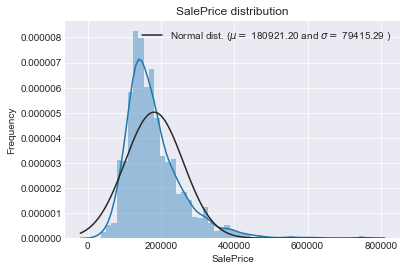

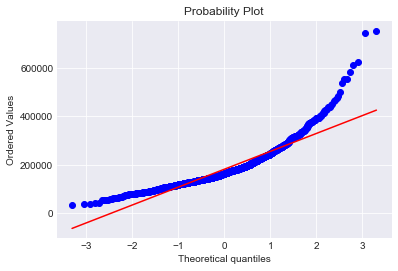

In [6]:
sns.distplot(train['SalePrice'] , fit=norm);

# 算一些關於SalePrice的數值(平均數，標準差)
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#畫出分佈圖以及常態分佈線
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#畫出QQ圖(分位圖)用來看出頻率分佈
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

可以看得出分佈圖的峰往左偏為positive skewness，且線性的model會喜歡常態分佈的data，所以我們要把data改造一下。

 **Log-transformation of the target variable**


 mu = 12.02 and sigma = 0.40



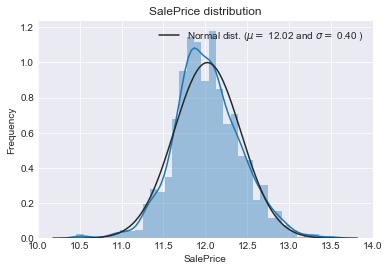

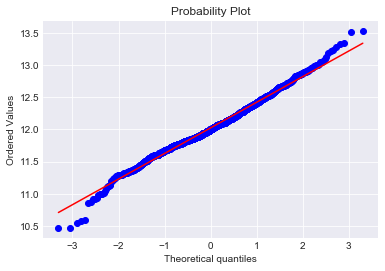

In [7]:
# 對所有值做 log(1+x)的處理，+1為了避免值為0 
train["SalePrice"] = np.log1p(train["SalePrice"])

#重新檢視圖
sns.distplot(train['SalePrice'] , fit=norm);

# 重新計算平均術和標準差
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

##畫出分佈圖以及常態分佈線
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#畫出QQ圖(分位圖)用來看出頻率分佈
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


現在看來，他的峰在中間且很接近常態分佈了。

## Features engineering

首先先將訓練(train)和測驗(test)的資料接在一起

In [8]:
#紀錄train和test的資料數目
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 79)


### Missing Data

In [9]:
#算出各個欄位的缺失Date的比例
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.657
MiscFeature,96.403
Alley,93.217
Fence,80.439
FireplaceQu,48.647
LotFrontage,16.650
GarageQual,5.447
GarageCond,5.447
GarageFinish,5.447
GarageYrBlt,5.447


Text(0.5,1,'Percent missing data by feature')

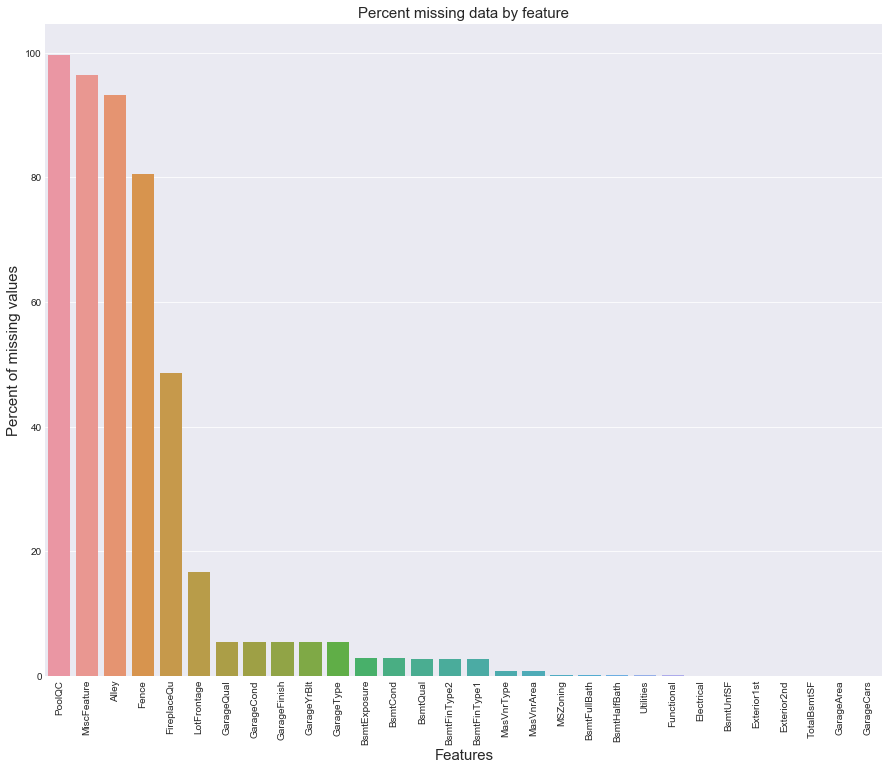

In [10]:
#以圖像的方式表示
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

**Data Correlation**


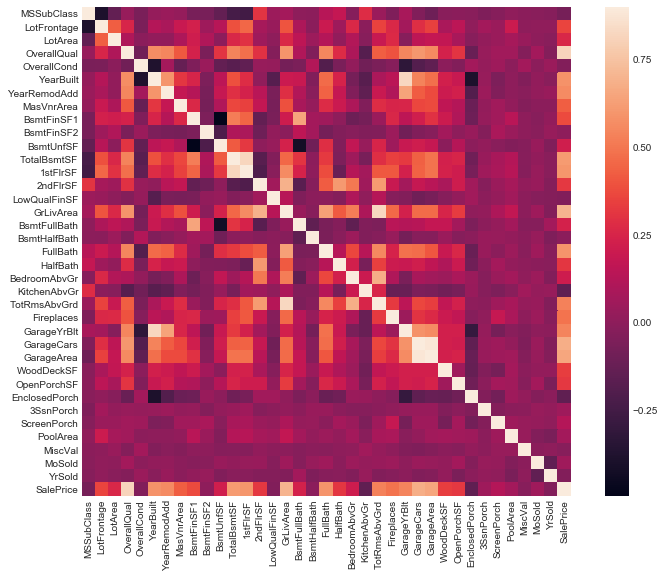

In [11]:
#印出關係圖來看看哪些資料和SalePrice有較大關係
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

### Imputing missing values 

我們依序將缺失的資料補全(沒有即代表None)

- **PoolQC** : data description says NA means "No  Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general. 

In [12]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

- **MiscFeature** : data description says NA means "no misc feature"


In [13]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

- **Alley** : data description says NA means "no alley access"

In [14]:
all_data["Alley"] = all_data["Alley"].fillna("None")

- **Fence** : data description says NA means "no fence"

In [15]:
all_data["Fence"] = all_data["Fence"].fillna("None")

- **FireplaceQu** : data description says NA means "no fireplace"

In [16]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

- **LotFrontage** : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can **fill in missing values by the median LotFrontage of the neighborhood**.

In [17]:
#將LotFrontage的值有缺失的藉由各個neighborhood的LotFrontage中位數來補全
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

- **GarageType, GarageFinish, GarageQual and GarageCond** : Replacing missing data with None

In [18]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

- **GarageYrBlt, GarageArea and GarageCars** : Replacing missing data with 0 (Since No garage = no cars in such garage.)


In [19]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

- **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath** : missing values are likely zero for having no basement

In [20]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

- **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : For all these categorical basement-related features, NaN means that there is no  basement.


In [21]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

- **MasVnrArea and MasVnrType** : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type. 


In [22]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

- **MSZoning (The general zoning classification)** :  'RL' is by far  the most common value.  So we can fill in missing values with 'RL'


In [23]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

- **Utilities** : For this categorical feature all records are "AllPub", except for one "NoSeWa"  and 2 NA . Since the house with 'NoSewa' is in the training set, **this feature won't help in predictive modelling**. We can then safely  remove it.


In [24]:
all_data = all_data.drop(['Utilities'], axis=1)

- **Functional** : data description says NA means typical

In [25]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

- **Electrical** : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.


In [26]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

- **KitchenQual**: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent)  for the missing value in KitchenQual.


In [27]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

- **Exterior1st and Exterior2nd** : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string


In [28]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

- **SaleType** : Fill in again with most frequent which is "WD"

In [29]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

- **MSSubClass** : Na most likely means No building class. We can replace missing values with None


In [30]:

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")



In [32]:
#看看還有沒有資料遺失 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


看起來沒有


### More features engeneering

**Transforming some numerical variables that are really categorical**
<br>(把一些非數字而是分類的變數轉換成數字)

In [33]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)



**Label Encoding some categorical variables that may contain information in their ordering set** <br>
藉由Label Encodeing 來保留他們藉由排序而有的資訊(不一定有，但有會保留)

In [34]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# 將分類的特徵藉由LabelEncoder來處理
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# 看看shape
print('Shape all_data: {}'.format(all_data.shape))




Shape all_data: (2919, 78)


**Adding one more important feature**
(加入新的重要特徵)

因為面積(類似坪數)和價格有非常大的關聯性，所以把1樓、2樓、地下室的面積通通加起來成為一個新的特徵

In [35]:
# 加入總面積的欄位
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']


**Skewed features**

In [36]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# 檢查所有數字類型特徵的Skewness(峰的偏左偏右度)
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)



Skew in numerical features: 



,Skew
MiscVal,21.947
PoolArea,16.898
LotArea,12.822
LowQualFinSF,12.089
3SsnPorch,11.376
LandSlope,4.975
KitchenAbvGr,4.302
BsmtFinSF2,4.146
EnclosedPorch,4.004
ScreenPorch,3.947


**Box Cox Transformation of (highly) skewed features**

We use the scipy  function boxcox1p which computes the Box-Cox transformation of **\\(1 + x\\)**. <br>
(用scipy的boxco1p函式來計算1+x的轉換)

Note that setting \\( \lambda = 0 \\) is equivalent to log1p used above for the target variable.  <br>
(設定lam為0相當於我們在上面做的log(x+1))

See [this page][1] for more details on Box Cox Transformation as well as [the scipy function's page][2]
[1]: http://onlinestatbook.com/2/transformations/box-cox.html
[2]: https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.special.boxcox1p.html

In [37]:
#當skewness的絕對值大於0.75時才處理
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 59 skewed numerical features to Box Cox transform


**Getting dummy categorical features**

In [38]:

all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2919, 221)


重新擷取train和test資料(因為改造過了)

In [40]:
#藉由之前紀錄過的資料數目來分割
train = all_data[:ntrain]
test = all_data[ntrain:]


# Modelling

**Import librairies**

In [41]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb



**Define a cross validation strategy**
(為了驗證我們訓練過後的準度，我們將訓練資料分成兩部分以交叉驗證)

我們用Sklearn的 **cross_val_score**函式 .但因為我們想將資料洗亂，所以我們要另外先做(cross_val_score沒提供)

In [42]:

n_folds = 5

#驗證函式
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## Base models

-  **LASSO  Regression**  : 

This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's  **Robustscaler()**  method on pipeline <br>
這個mode對於outlier十分敏感，所以我們*藉由pipeline先用**Robustscaler()*來處理資料

In [43]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

- **Elastic Net Regression** :

again made robust to outliers<br>
一樣讓他對outlier有抵抗性

In [44]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

- **Kernel Ridge Regression** :

In [45]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

- **Gradient Boosting Regression** :

With **huber**  loss that makes it robust to outliers<br>
選擇huber的loss函式一樣能對outlier有更高的抵抗能力

In [46]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

- **XGBoost** :

In [47]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)



- **LightGBM** :

In [48]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

### Base models scores

Let's see how these base models perform on the data by evaluating the  cross-validation rmsle error<br>
看看每個model在交叉驗證中的錯誤分數


In [49]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1240 (0.0165)



In [50]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1240 (0.0165)



In [51]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1262 (0.0127)



In [52]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1248 (0.0130)



In [53]:

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1223 (0.0102)



In [54]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1222 (0.0088)



## Stacking  models

### Simplest Stacking approach : Averaging base models

We begin with this simple approach of averaging base models.  We build a new **class**  to extend scikit-learn with our model and also to laverage encapsulation and code reuse ([inheritance][1]) <br>
我們建設一個**class**來封裝這些mode以平均他們，以提升效果

  [1]: https://en.wikipedia.org/wiki/Inheritance_(object-oriented_programming)

**Averaged base models class**

In [56]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # 我們複製多個原始model來input資料
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # 訓練所有的model
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #然後讓所有的model做預測並平均答案
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

**Averaged base models score**

We just average four models here **ENet, GBoost,  KRR and lasso**.  Of course we could easily add more models in the mix. <br>
我們只平均4個model在**ENet, GBoost,  KRR and lasso**上，當然我們也能用更多model

In [57]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1197 (0.0147)



Wow ! It seems even the simplest stacking approach really improve the score . This encourages 
us to go further and explore a less simple stacking approch. 
這看起來簡單的多個model並平均能提升效能，值得我們深入探索一些stack的方法。

### Less simple Stacking : Adding a Meta-model

In this approach, we add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model. 

The procedure, for the training part, may be described as follows:


1. Split the total training set into two disjoint sets (here **train** and .**holdout** )

2. Train several base models on the first part (**train**)

3. Test these base models on the second part (**holdout**)

4. Use the predictions from 3)  (called  out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs  to train a higher level learner called **meta-model**.

The first three steps are done iteratively . If we take for example a 5-fold stacking , we first split the training data into 5 folds. Then we will do 5 iterations. In each iteration,  we train every base model on 4 folds and predict on the remaining fold (holdout fold). 

So, we will be sure, after 5 iterations , that the entire data is used to get out-of-folds predictions that we will then use as 
new feature to train our meta-model in the step 4.

For the prediction part , We average the predictions of  all base models on the test data  and used them as **meta-features**  on which, the final prediction is done with the meta-model.


![Faron](http://i.imgur.com/QBuDOjs.jpg)

(Image taken from [Faron](https://www.kaggle.com/getting-started/18153#post103381))

![kaz](http://5047-presscdn.pagely.netdna-cdn.com/wp-content/uploads/2017/06/image5.gif)

Gif taken from [KazAnova's interview](http://blog.kaggle.com/2017/06/15/stacking-made-easy-an-introduction-to-stacknet-by-competitions-grandmaster-marios-michailidis-kazanova/)

On this gif, the base models are algorithms 0, 1, 2 and the meta-model is algorithm 3. The entire training dataset is 
A+B (target variable y known) that we can split into train part (A) and holdout part (B). And the test dataset is C. 

B1 (which is the prediction from the holdout part)  is the new feature used to train the meta-model 3 and C1 (which
is the prediction  from the test dataset) is the meta-feature on which the final prediction is done. 

**Stacking averaged Models Class**

In [58]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

**Stacking Averaged models Score**

To make the two approaches comparable (by using the same number of models) , we just average **Enet KRR and Gboost**, then we add **lasso as meta-model**.

In [59]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1194 (0.0143)


We get again a better score by adding a meta learner

## Ensembling StackedRegressor, XGBoost and LightGBM

We add **XGBoost and LightGBM** to the** StackedRegressor** defined previously. 

We first define a rmsle evaluation function 

In [60]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

### Final Training and Prediction

**StackedRegressor:**

In [61]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.07969221704842223


**XGBoost:**

In [62]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.07887849761685559


**LightGBM:**

In [63]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.07458283769830473


In [64]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.07647718640340939


**Ensemble prediction:**

In [65]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

**Submission**

In [75]:
sub = pd.DataFrame()
sub['Id'] = test.index
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)

我很大一部份都是直接抄這份文章[文章](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard/code)<br>
因為最高的分數都在這，而另一份ipy檔則是之前實驗和嘗試的部分。


![avatar](https://imgur.com/a/05cHDaK.png)